# For any modifications, initially use this notebook as a starting point. Duplicate the notebook and start from there.

Imports

In [1]:
import os
from typing import Generator, List, Optional, Tuple

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from torchvision.datasets import CIFAR10

Constants


In [2]:
MAX_ITERATIONS: int = 10000
RESOLUTION: Tuple[int, int] = (64, 64)

# SVC Model

LFW dataset loading (positive class)

In [3]:
def load_lfw_positive_images(target_size: Tuple[int, int] = RESOLUTION) -> Tuple[np.ndarray, int]:
    """
    Loads the LFW dataset, extracts positive images, and resizes them to the target size.

    :param target_size: The target size (width, height) for resizing the images.
    :return: A tuple containing the NumPy array of resized positive images and the count of positive images.
    """
    lfw = fetch_lfw_people(color=True, funneled=True, resize=1.0)
    pos_img: np.ndarray = lfw.images
    pos_cnt: int = pos_img.shape[0]

    pos_resized: np.ndarray = np.array([cv2.resize(img, target_size) for img in pos_img])
    return pos_resized, pos_cnt

In [4]:
positive_images: np.ndarray
positive_count: int
positive_images, positive_count = load_lfw_positive_images(target_size=RESOLUTION)
print(positive_count)

13233


CIFAR-10 dataset loading (negative class)

In [5]:
def load_cifar10_negative_images(data_path: str = './data', target_size: Tuple[int, int] = RESOLUTION) -> Tuple[np.ndarray, int]:
    """
    Loads the CIFAR-10 dataset, resizes images to the target size, and extracts negative images as a single NumPy array.

    :param data_path: Path to download and store the CIFAR-10 dataset.
    :param target_size: The target size (width, height) for resizing the images.
    :return: A tuple containing the NumPy array of resized negative images and their count.
    """
    cifar10_dataset = CIFAR10(
        root=data_path,
        train=True,
        download=True
    )

    neg_img: np.ndarray = np.array([
        cv2.resize(np.array(img), target_size) for img, _ in cifar10_dataset
    ])
    neg_cnt: int = len(neg_img)

    return neg_img, neg_cnt

In [6]:
negative_images: np.ndarray
negative_count: int
negative_images, negative_count = load_cifar10_negative_images()
print(negative_count)

50000


HOG feature extraction (skimage implementation is slow but works well, CV2 is fast but doesn't work well)

In [7]:
# def extract_hog_features(image: np.ndarray,
#                          pixels_per_cell: Tuple[int, int] = (8, 8),
#                          cells_per_block: Tuple[int, int] = (2, 2),
#                          orientations: int = 9) -> np.ndarray:
#     """
#     Extract HOG (Histogram of Oriented Gradients) features using OpenCV's implementation.
#
#     :param image: The input image as a NumPy array. If color, will be converted to grayscale.
#     :param pixels_per_cell: The size of each cell in pixels (width, height).
#     :param cells_per_block: The number of cells per block (width, height).
#     :param orientations: The number of orientation bins for the histograms.
#     :return: The HOG feature vector as a NumPy array.
#     """
#     if len(image.shape) > 2:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#
#     image_uint8 = image.astype(np.uint8)
#
#     win_size = image_uint8.shape[::-1]
#     block_size = (cells_per_block[1] * pixels_per_cell[1],
#                   cells_per_block[0] * pixels_per_cell[0])
#     block_stride = (pixels_per_cell[1], pixels_per_cell[0])
#     cell_size = (pixels_per_cell[1], pixels_per_cell[0])
#
#     hog = cv2.HOGDescriptor(_winSize=win_size,
#                             _blockSize=block_size,
#                             _blockStride=block_stride,
#                             _cellSize=cell_size,
#                             _nbins=orientations)
#
#     features = hog.compute(image_uint8)
#     return features.flatten()

def extract_hog_features(image: np.ndarray,
                         pixels_per_cell: Tuple[int, int] = (8, 8),
                         cells_per_block: Tuple[int, int] = (2, 2),
                         orientations: int = 9) -> np.ndarray:
    """
    Extracts HOG (Histogram of Oriented Gradients) descriptors from an image.

    :param image: The input image as a NumPy array.
    :param pixels_per_cell: The size of each cell in pixels (width, height).
    :param cells_per_block: The number of cells per block (width, height).
    :param orientations: The number of orientation bins for the histograms.
    :return: The HOG feature vector as a NumPy array.
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(image, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys', visualize=True)
    return features

Loading the dataset

In [8]:
def load_dataset(pos_img: np.ndarray,
                 neg_img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load dataset with optimized parallel HOG feature extraction and shuffle the data.

    :param pos_img: Array of positive class images.
    :param neg_img: Array of negative class images.
    :return: A tuple containing the shuffled feature matrix (data_X) and the label vector (labels_y).
    """
    total_images = len(pos_img) + len(neg_img)
    feature_length = len(extract_hog_features(pos_img[0]))

    data_X = np.zeros((total_images, feature_length), dtype=np.float32)
    labels_y = np.zeros(total_images, dtype=np.int32)

    n_pos = len(pos_img)
    for i, img in enumerate(pos_img):
        data_X[i] = extract_hog_features(img)

    labels_y[:n_pos] = 1

    for i, img in enumerate(neg_img):
        data_X[i + n_pos] = extract_hog_features(img)

    indices = np.random.permutation(total_images)
    data_X = data_X[indices]
    labels_y = labels_y[indices]

    return data_X, labels_y

In [9]:
X: np.ndarray
Y: np.ndarray
X, Y = load_dataset(positive_images, negative_images)
print("Dataset size:", X.shape, Y.shape)

Dataset size: (63233, 1764) (63233,)


Training the SVC (already trained, can be loaded from the commented line)

In [10]:
if not os.path.exists("model"):
    os.makedirs("model")

filename: str = "model/svm.joblib"

In [11]:
# svc: SVC = joblib.load(filename)

svc: SVC = SVC(kernel="rbf", max_iter=MAX_ITERATIONS)
svc.fit(X, Y)

joblib.dump(svc, filename)

pred_train: np.ndarray = svc.predict(X)
print("Classification report (training data):")
print(classification_report(Y, pred_train))

Classification report (training data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       1.00      1.00      1.00     13233

    accuracy                           1.00     63233
   macro avg       1.00      1.00      1.00     63233
weighted avg       1.00      1.00      1.00     63233



# Face detection pipeline

Image pyramid generator, for image scaling

In [12]:
def image_pyramid(image: np.ndarray, scale: float = 1.5, minSize: Tuple[int, int] = RESOLUTION) -> Generator[np.ndarray, None, None]:
    """
    Generates an image pyramid.

    :param image: The original image as a NumPy array.
    :param scale: The scaling factor for resizing the image.
    :param minSize: The minimum size (width, height) at which resizing stops.
    :yield: The resized image as a NumPy array.
    """
    yield image
    while True:
        w: int = int(image.shape[1] / scale)
        h: int = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

Sliding window generator, for extracting patches from the image

In [13]:
def sliding_window(image: np.ndarray, stepSize: int, windowSize: Tuple[int, int]) -> Generator[Tuple[int, int, np.ndarray], None, None]:
    """
    Iterates over an image with a sliding window.

    :param image: The image to iterate over as a NumPy array.
    :param stepSize: The step size for moving the window.
    :param windowSize: The size of the window (width, height).
    :yield: The coordinates (x, y) and the extracted patch as a NumPy array.
    """
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
            yield x, y, image[y:y + windowSize[1], x:x + windowSize[0]]

Non-Maximum Suppression (NMS)

In [14]:
def non_max_suppression(boxes: List[Tuple[int, int, int, int]], overlapThresh: float = 0.3) -> List[Tuple[int, int, int, int]]:
    if len(boxes) == 0:
        return []

    boxes_np = np.array(boxes)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = x1 + boxes_np[:, 2]
    y2 = y1 + boxes_np[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    indexes = np.argsort(areas)[::-1]

    picked = []
    while len(indexes) > 0:
        i = indexes[0]
        picked.append(i)

        xx1 = np.maximum(x1[i], x1[indexes[1:]])
        yy1 = np.maximum(y1[i], y1[indexes[1:]])
        xx2 = np.minimum(x2[i], x2[indexes[1:]])
        yy2 = np.minimum(y2[i], y2[indexes[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        overlap = (w * h) / areas[indexes[1:]]
        indexes = np.delete(indexes, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1)))

    return [boxes[i] for i in picked]

Detection function

In [15]:
def detect_faces(image: np.ndarray,
                 svm: SVC,
                 window_size: Tuple[int, int] = RESOLUTION,
                 stepSize: int = 16,
                 scale: float = 1.5) -> List[Tuple[int, int, int, int]]:
    detections: List[Tuple[int, int, int, int]] = []
    for im_scaled in image_pyramid(image, scale=scale, minSize=window_size):
        scale_factor: float = image.shape[0] / im_scaled.shape[0]
        for (x, y, window) in sliding_window(im_scaled, stepSize, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            features: np.ndarray = extract_hog_features(window)
            prediction: np.ndarray = svm.predict([features])
            if prediction == 1:
                detections.append((int(x * scale_factor), int(y * scale_factor),
                                   int(window_size[0] * scale_factor), int(window_size[1] * scale_factor)))

    return non_max_suppression(detections, overlapThresh=0.3)


Visualization function

In [16]:
def visualize_face_detections(test_image_path: str,
                              svm: SVC,
                              stepSize: int = 16,
                              scale: float = 1.5) -> None:
    """
    Visualizes face detections on a test image using a trained SVM model.

    :param test_image_path: Path to the test image.
    :param svm: A trained SVC model for face detection.
    :param stepSize: The step size for the sliding window.
    :param scale: The scaling factor for the image pyramid.
    """
    test_image: Optional[np.ndarray] = cv2.imread(test_image_path)
    if test_image is not None:
        detections = detect_faces(test_image, svm, stepSize=stepSize, scale=scale)

        for (x, y, w, h) in detections:
            cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        plt.title("Face Detections")
        plt.axis("off")
        plt.show()
    else:
        print("Test image not found.")

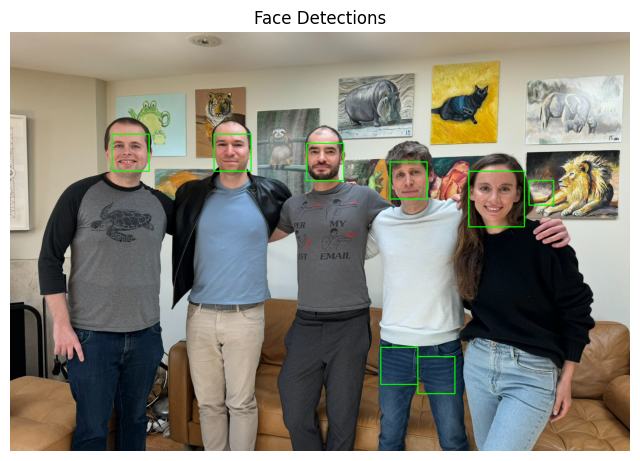

In [17]:
visualize_face_detections("../test_data/test.jpg", svc)